In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline
from scipy import stats
import shap

import warnings
warnings.filterwarnings("ignore")

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.inprocessing.prejudice_remover import PrejudiceRemover
from aif360.algorithms.preprocessing import DisparateImpactRemover

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

/home/juliana/miniconda3/envs/pytevec/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Functions

def consitency_mod(metric, col,n_neighbors=5):
    #Function to calculate consistency
    X = metric.dataset.features
    X = np.delete(X, col, 1)
    X = StandardScaler().fit_transform(X) 
    num_samples = X.shape[0]
    y = metric.dataset.labels

    # learn a KNN on the features
    nbrs = NearestNeighbors(n_neighbors, algorithm='ball_tree').fit(X)
    _, indices = nbrs.kneighbors(X)

    # compute consistency score
    consistency = 0.0
    for i in range(num_samples):
        consistency += np.abs(y[i] - np.mean(y[indices[i]]))
    consistency = 1.0 - consistency/num_samples

    return consistency

## Loading data

In [3]:
path = ''
df_original = pd.read_csv(path + 'data/german.data', sep=' ', header=None)
df_original.columns = ['status_account', 'duration_month', 'credit_history', 'purpose',
                       'credit_amount', 'savings_account', 'employment_since', 'installment_rate',
                       'sex', 'other_debtors', 'residence_since', 'property', 'age', 
                       'installment_plans', 'housing', 'number_credits_this_bank', 'job', 
                       'people_liable_for', 'telephone', 'foreign_worker', 'credit_risk']
print(df_original.shape)
df_original.head()

(1000, 21)


,status_account,duration_month,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,sex,other_debtors,...,property,age,installment_plans,housing,number_credits_this_bank,job,people_liable_for,telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


## Preprocessing

In [4]:
df_proces = df_original.copy()

df_proces['credit_risk'] = df_proces['credit_risk'].apply(lambda row: 1 if row == 1 else 0)
df_proces['age'] = df_proces['age'].apply(lambda row: 0 if row <= 25 else 1)
columns_cat = ['sex', 'status_account', 'credit_history', 'purpose', 'savings_account',
               'employment_since', 'other_debtors', 'property', 'installment_plans',
               'housing', 'job', 'telephone', 'foreign_worker']

lb_encoder = LabelEncoder()
for col_cat in columns_cat:  
    df_proces[col_cat] = lb_encoder.fit_transform(df_proces[col_cat])

df_proces = df_proces.astype(float)
df_proces.head()

,status_account,duration_month,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,sex,other_debtors,...,property,age,installment_plans,housing,number_credits_this_bank,job,people_liable_for,telephone,foreign_worker,credit_risk
0,0.0,6.0,4.0,4.0,1169.0,4.0,4.0,4.0,2.0,0.0,...,0.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0
1,1.0,48.0,2.0,4.0,5951.0,0.0,2.0,2.0,1.0,0.0,...,0.0,0.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0
2,3.0,12.0,4.0,7.0,2096.0,0.0,3.0,2.0,2.0,0.0,...,0.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0
3,0.0,42.0,2.0,3.0,7882.0,0.0,3.0,2.0,2.0,2.0,...,1.0,1.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,1.0
4,0.0,24.0,3.0,0.0,4870.0,0.0,2.0,3.0,2.0,0.0,...,3.0,1.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0


In [8]:
for col_cat in columns_cat:  
    one_hot = OneHotEncoder(sparse=False)
    res = one_hot.fit_transform(df_proces[[col_cat]])
    num_col = res.shape[1]
    for idx in range(num_col):
        df_proces['{}_{}'.format(col_cat, idx)] = res[:, idx]
        
df_proces.drop(columns_cat, axis=1, inplace=True)
df_proces.head()

,duration_month,credit_amount,installment_rate,residence_since,age,number_credits_this_bank,people_liable_for,credit_risk,sex_0,sex_1,sex_2,sex_3,status_account_0,status_account_1,status_account_2,status_account_3,credit_history_0,credit_history_1,credit_history_2,credit_history_3,credit_history_4,purpose_0,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,savings_account_0,savings_account_1,savings_account_2,savings_account_3,savings_account_4,employment_since_0,employment_since_1,employment_since_2,employment_since_3,employment_since_4,other_debtors_0,other_debtors_1,other_debtors_2,property_0,property_1,property_2,property_3,installment_plans_0,installment_plans_1,installment_plans_2,housing_0,housing_1,housing_2,job_0,job_1,job_2,job_3,telephone_0,telephone_1,foreign_worker_0,foreign_worker_1
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [11]:
metadata = {'label_maps': [{0.0: 'Bad', 1.0: 'Good'}], 
            'protected_attribute_maps': [{0.0: 'young', 1.0: 'aged'}]}
unprivileged_groups=[{'age': [0.0]}]
privileged_groups=[{'age': [1.0]}]
protected_attribute_names = ['age']
label_names = ['credit_risk']
dataset = BinaryLabelDataset(df = df_proces, label_names=label_names, 
                            protected_attribute_names = protected_attribute_names, 
                            instance_weights_name=None, unprivileged_protected_attributes=[], 
                            privileged_protected_attributes=[], metadata=metadata)

metric_orig = BinaryLabelDatasetMetric(dataset,
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
disparate_impact_orig = metric_orig.disparate_impact()
print('Disparate impact dados originais: ', (1 - disparate_impact_orig))
position = 4

Disparate impact dados originais:  0.20517395182872433


In [0]:
lst_res = []

## Model with original data

In [0]:
dataset_train, dataset_test = dataset.split([0.7], shuffle=False)

scale = StandardScaler().fit(dataset_train.features)
X_train_orig = scale.transform(dataset_train.features)
y_train = dataset_train.labels.ravel()
X_test_orig = scale.transform(dataset_test.features)
y_test = dataset_test.labels.ravel()

### Random Forest

In [18]:
model_orig_rf = RandomForestClassifier()
model_orig_rf.fit(X_train_orig, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
y_pred_test = model_orig_rf.predict(X_test_orig)
acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)
y_pred_train = model_orig_rf.predict(X_train_orig)
acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print("Acuracia treino: ", acc_train)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_orig_pred_rf = BinaryLabelDatasetMetric(dataset_pred,
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)
disparate_impact_orig_pred_rf = metric_orig_pred_rf.disparate_impact()
print('Disparate impact previsão com dados originais: ', (1 - disparate_impact_orig_pred_rf))
mean_difference_orig_pred_rf = metric_orig_pred_rf.mean_difference()
print('Mean difference previsão com dados originais: ', mean_difference_orig_pred_rf)

classif_metric_orig_pred_rf = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_orig_pred_rf = classif_metric_orig_pred_rf.disparate_impact()
print('Classif. disparete previsão com dados originais', 1 - classif_disparete_impact_orig_pred_rf)
avg_odds_orig_pred_rf = classif_metric_orig_pred_rf.average_odds_difference()
print('average_odds_difference previsão com dados originais:', avg_odds_orig_pred_rf)
equal_opport_orig_pred_rf = classif_metric_orig_pred_rf.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados originais:', equal_opport_orig_pred_rf)
false_discovery_rate_orig_pred_rf = classif_metric_orig_pred_rf.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados originais:', false_discovery_rate_orig_pred_rf)
cons_comp_orig_pred_rf = consitency_mod(metric_orig_pred_rf, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_orig_pred_rf)
entropy_index_orig_pred_rf = classif_metric_orig_pred_rf.generalized_entropy_index()
print('generalized_entropy_index previsão com dados originais:', entropy_index_orig_pred_rf)

lst_res.append(('adult', 'rf_orig', acc_test, 1-disparate_impact_orig_pred_rf, mean_difference_orig_pred_rf,
                1 - classif_disparete_impact_orig_pred_rf, avg_odds_orig_pred_rf, equal_opport_orig_pred_rf,
                false_discovery_rate_orig_pred_rf, entropy_index_orig_pred_rf, cons_comp_orig_pred_rf))

Acuracia teste:  0.76
Acuracia treino:  0.9942857142857143
Disparate impact previsão com dados originais:  0.14412024756852337
Mean difference previsão com dados originais:  -0.11612995155314898
Classif. disparete previsão com dados originais 0.14412024756852337
average_odds_difference previsão com dados originais: -0.036684360836903185
equal_opportunity_difference previsão com dados originais: -0.07062146892655363
false_discovery_rate_difference previsão com dados originais: 0.1955128205128205
Consistency comparative:  0.7926666666666665
generalized_entropy_index previsão com dados originais: 0.09674301011302801


### Logistic Regression

In [20]:
model_orig_lr = LogisticRegression()
model_orig_lr.fit(X_train_orig, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
y_pred_test = model_orig_lr.predict(X_test_orig)
acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)
y_pred_train = model_orig_lr.predict(X_train_orig)
acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print("Acuracia treino: ", acc_train)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_orig_pred_lr = BinaryLabelDatasetMetric(dataset_pred,
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)
disparate_impact_orig_pred_lr = metric_orig_pred_lr.disparate_impact()
print('Disparate impact previsão com dados originais: ', (1 - disparate_impact_orig_pred_lr))
mean_difference_orig_pred_lr = metric_orig_pred_lr.mean_difference()
print('Mean difference previsão com dados originais: ', mean_difference_orig_pred_lr)

classif_metric_orig_pred_lr = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_orig_pred_lr = classif_metric_orig_pred_lr.disparate_impact()
print('Classif. disparete previsão com dados originais', 1 - classif_disparete_impact_orig_pred_lr)
avg_odds_orig_pred_lr = classif_metric_orig_pred_lr.average_odds_difference()
print('average_odds_difference previsão com dados originais:', avg_odds_orig_pred_lr)
equal_opport_orig_pred_lr = classif_metric_orig_pred_lr.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados originais:', equal_opport_orig_pred_lr)
false_discovery_rate_orig_pred_lr = classif_metric_orig_pred_lr.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados originais:', false_discovery_rate_orig_pred_lr)
cons_comp_orig_pred_lr = consitency_mod(metric_orig_pred_lr, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_orig_pred_lr)

entropy_index_orig_pred_lr = classif_metric_orig_pred_lr.generalized_entropy_index()
print('generalized_entropy_index previsão com dados originais:', entropy_index_orig_pred_lr)
lst_res.append(('adult', 'lr_orig', acc_test, 1-disparate_impact_orig_pred_lr, mean_difference_orig_pred_lr,
                1 - classif_disparete_impact_orig_pred_lr, avg_odds_orig_pred_lr, equal_opport_orig_pred_lr,
                false_discovery_rate_orig_pred_lr, entropy_index_orig_pred_lr, cons_comp_orig_pred_lr))

Acuracia teste:  0.7633333333333333
Acuracia treino:  0.7885714285714286
Disparate impact previsão com dados originais:  0.2931976634633504
Mean difference previsão com dados originais:  -0.22171558848674844
Classif. disparete previsão com dados originais 0.2931976634633504
average_odds_difference previsão com dados originais: -0.12953374309306515
equal_opportunity_difference previsão com dados originais: -0.17005649717514126
false_discovery_rate_difference previsão com dados originais: 0.16411069980609905
Consistency comparative:  0.8106666666666666
generalized_entropy_index previsão com dados originais: 0.11273859669598603


## Model with transformed data

In [0]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(dataset_train)
dataset_transf_train = RW.transform(dataset_train)

In [23]:
metric_transf = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
disparate_impact_transf = metric_transf.disparate_impact()
print('Disparate impact dados transformados: ', (1 - disparate_impact_transf))

Disparate impact dados transformados:  1.1102230246251565e-16


In [0]:
scale_transf = StandardScaler().fit(dataset_transf_train.features) 
X_train_transf = scale.transform(dataset_transf_train.features)  
y_train = dataset_transf_train.labels.ravel()
X_test_transf = scale_transf.transform(dataset_test.features) 
y_test = dataset_test.labels.ravel()

### Random Forest

In [25]:
model_transf_rf = RandomForestClassifier()
model_transf_rf.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
y_pred_test = model_transf_rf.predict(X_test_transf)

acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_pred_transf_rf = BinaryLabelDatasetMetric(dataset_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
disparate_impact_transf_pred_rf = metric_pred_transf_rf.disparate_impact()
mean_difference_transf_pred_rf = metric_pred_transf_rf.mean_difference()
print('Disparate impact previsão com dados transformados: ', (1 - disparate_impact_transf_pred_rf))
print('Mean difference previsão com dados transformados: ', mean_difference_transf_pred_rf)

classif_metric_transf_pred_rf = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_transf_pred_rf = classif_metric_transf_pred_rf.disparate_impact()
print('Classif. disparete previsão com dados transformados', 1 - classif_disparete_impact_transf_pred_rf)
avg_odds_transf_pred_rf = classif_metric_transf_pred_rf.average_odds_difference()
print('average_odds_difference previsão com dados transformados:', avg_odds_transf_pred_rf)
equal_opport_transf_pred_rf = classif_metric_transf_pred_rf.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados transformados:', equal_opport_transf_pred_rf)
false_discovery_rate_transf_pred_rf = classif_metric_transf_pred_rf.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados transformados:', false_discovery_rate_transf_pred_rf)
cons_comp_transf_pred_rf = consitency_mod(metric_pred_transf_rf, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_transf_pred_rf)

entropy_index_transf_pred_rf = classif_metric_transf_pred_rf.generalized_entropy_index()
print('generalized_entropy_index previsão com dados transformados:', entropy_index_transf_pred_rf)
lst_res.append(('adult', 'rf_transf', acc_test, 1-disparate_impact_transf_pred_rf, 
                mean_difference_transf_pred_rf, 1 - classif_disparete_impact_transf_pred_rf,
                avg_odds_transf_pred_rf, equal_opport_transf_pred_rf,
                false_discovery_rate_transf_pred_rf, entropy_index_transf_pred_rf, cons_comp_transf_pred_rf))

Acuracia teste:  0.7533333333333333
Disparate impact previsão com dados transformados:  0.1784884759692693
Mean difference previsão com dados transformados:  -0.14234824736392138
Classif. disparete previsão com dados transformados 0.1784884759692693
average_odds_difference previsão com dados transformados: -0.0655584528465884
equal_opportunity_difference previsão com dados transformados: -0.09265536723163836
false_discovery_rate_difference previsão com dados transformados: 0.18707390237251156
Consistency comparative:  0.7839999999999999
generalized_entropy_index previsão com dados transformados: 0.1029949702789208


### Logistic Regression

In [27]:
model_transf_lr = LogisticRegression()
model_transf_lr.fit(X_train_transf, y_train,
                    sample_weight=dataset_transf_train.instance_weights)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
y_pred_test = model_transf_lr.predict(X_test_transf)

acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_pred_transf_lr = BinaryLabelDatasetMetric(dataset_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
disparate_impact_transf_pred_lr = metric_pred_transf_lr.disparate_impact()
mean_difference_transf_pred_lr = metric_pred_transf_lr.mean_difference()
print('Disparate impact previsão com dados transformados: ', (1 - disparate_impact_transf_pred_lr))
print('Mean difference previsão com dados transformados: ', mean_difference_transf_pred_lr)

classif_metric_transf_pred_lr = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_transf_pred_lr = classif_metric_transf_pred_lr.disparate_impact()
print('Classif. disparete previsão com dados transformados', 1 - classif_disparete_impact_transf_pred_lr)
avg_odds_transf_pred_lr = classif_metric_transf_pred_lr.average_odds_difference()
print('average_odds_difference previsão com dados transformados:', avg_odds_transf_pred_lr)
equal_opport_transf_pred_lr = classif_metric_transf_pred_lr.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados transformados:', equal_opport_transf_pred_lr)
false_discovery_rate_transf_pred_lr = classif_metric_transf_pred_lr.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados transformados:', false_discovery_rate_transf_pred_lr)
cons_comp_transf_pred_lr = consitency_mod(metric_pred_transf_lr, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_transf_pred_lr)
entropy_index_transf_pred_lr = classif_metric_transf_pred_lr.generalized_entropy_index()
print('generalized_entropy_index previsão com dados transformados:', entropy_index_transf_pred_lr)
lst_res.append(('adult', 'lr_transf', acc_test, 1-disparate_impact_transf_pred_lr, 
                mean_difference_transf_pred_lr, 1 - classif_disparete_impact_transf_pred_lr, 
                avg_odds_transf_pred_lr, equal_opport_transf_pred_lr,
                false_discovery_rate_transf_pred_lr, entropy_index_transf_pred_lr, cons_comp_transf_pred_lr))

Acuracia teste:  0.7566666666666667
Disparate impact previsão com dados transformados:  0.037135278514588865
Mean difference previsão com dados transformados:  -0.027928184667996625
Classif. disparete previsão com dados transformados 0.037135278514588865
average_odds_difference previsão com dados transformados: 0.06982523126590923
equal_opportunity_difference previsão com dados transformados: -0.03672316384180785
false_discovery_rate_difference previsão com dados transformados: 0.2509157509157509
Consistency comparative:  0.8093333333333332
generalized_entropy_index previsão com dados transformados: 0.10752918229856


In [0]:
cols_name = ['dataset', 'name_exp', 'acc_test', '1_disp_impact_bin', 'mean_difference',
             '1_disp_impact_clf', 'avg_odds', 'equal_opport', 'false_discovery_rate',
             'entropy_index', 'consistency']

df_final = pd.DataFrame(lst_res, columns=cols_name)

In [30]:
df_final

,dataset,name_exp,acc_test,1_disp_impact_bin,mean_difference,1_disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,adult,rf_orig,0.760000,0.144120,-0.116130,0.144120,-0.036684,-0.070621,0.195513,0.096743,0.792667
1,adult,lr_orig,0.763333,0.293198,-0.221716,0.293198,-0.129534,-0.170056,0.164111,0.112739,0.810667
2,adult,rf_transf,0.753333,0.178488,-0.142348,0.178488,-0.065558,-0.092655,0.187074,0.102995,0.784000
3,adult,lr_transf,0.756667,0.037135,-0.027928,0.037135,0.069825,-0.036723,0.250916,0.107529,0.809333


## SHAP

### Random Forest

In [0]:
lst_shape = []
position = 4
name_protect = 'age'

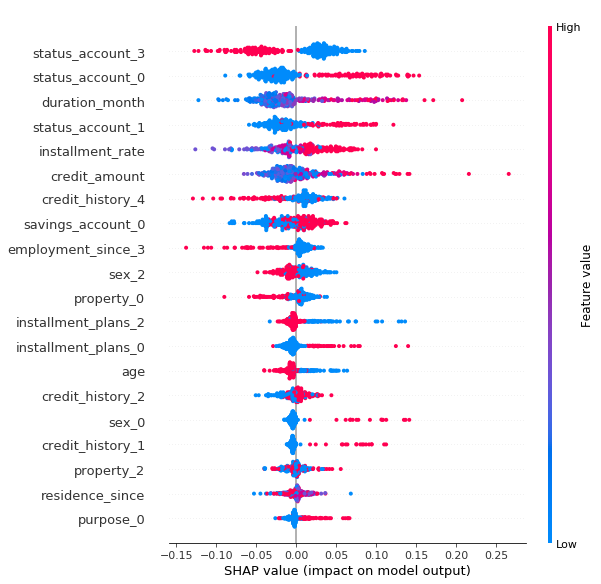

In [32]:
exp_transf = shap.TreeExplainer(model_transf_rf, X_train_transf)
shap_values_transf = exp_transf.shap_values(X_test_transf)
shap.summary_plot(shap_values_transf[0], X_test_transf, feature_names=dataset.feature_names)

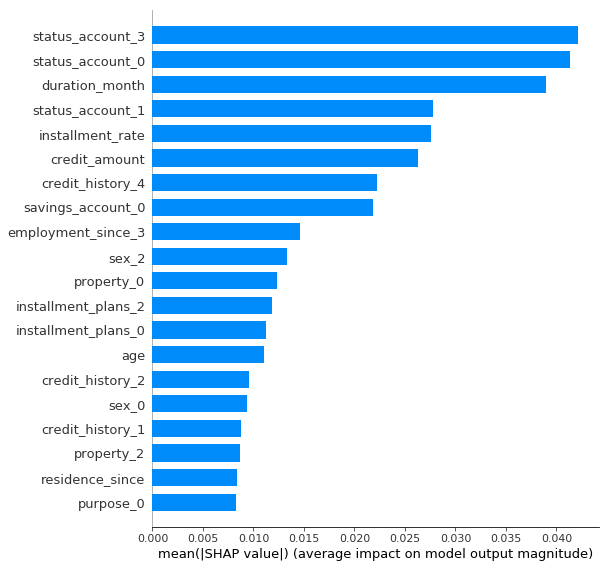

In [33]:
shap.summary_plot(shap_values_transf[0], X_test_transf, feature_names=dataset.feature_names, plot_type="bar")


In [34]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_transf[0]).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_transf_rf = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_transf_rf = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,status_account_3,0.042089
1,status_account_0,0.041362
2,duration_month,0.039004
3,status_account_1,0.027798
4,installment_rate,0.027604
5,credit_amount,0.026247
6,credit_history_4,0.022188
7,savings_account_0,0.021785
8,employment_since_3,0.014559
9,sex_2,0.013299


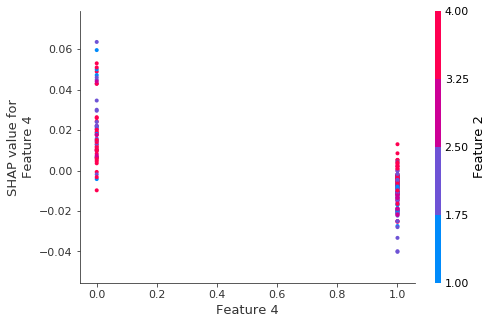

In [35]:
shap.dependence_plot(position, shap_values_transf[0], dataset_test.features)

In [36]:
df = pd.DataFrame({'shap': shap_values_transf[0][:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_transf_rf = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_transf_rf = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_transf_rf)
print('Media valores SHAP classe priveligiada: ', priv_value_transf_rf)

Media valores SHAP classe não priveligiada:  0.020982439672077646
Media valores SHAP classe priveligiada:  -0.007988950067441623


In [37]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0    

accept null hypothesis


In [0]:
lst_shape.append(('rf_transf', feat_import_transf_rf, pos_transf_rf,
                  unp_value_transf_rf, priv_value_transf_rf, priv_greater_unpriv))

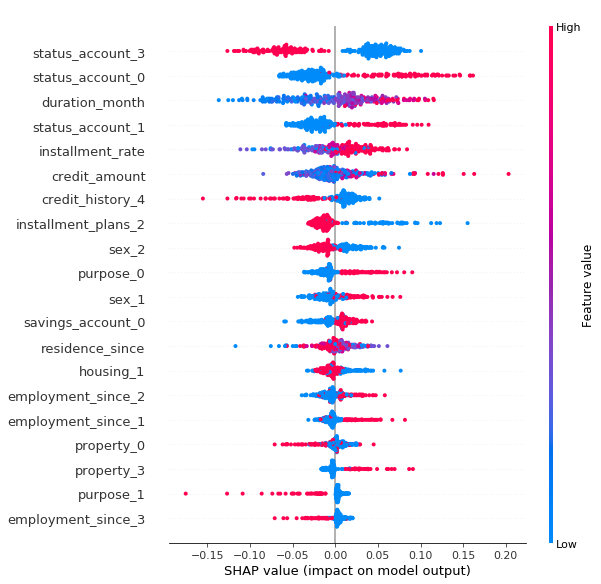

In [39]:
exp_orig = shap.TreeExplainer(model_orig_rf, X_train_orig)
shap_values_orig = exp_orig.shap_values(X_test_orig)
shap.summary_plot(shap_values_orig[0], X_test_orig, feature_names=dataset.feature_names)

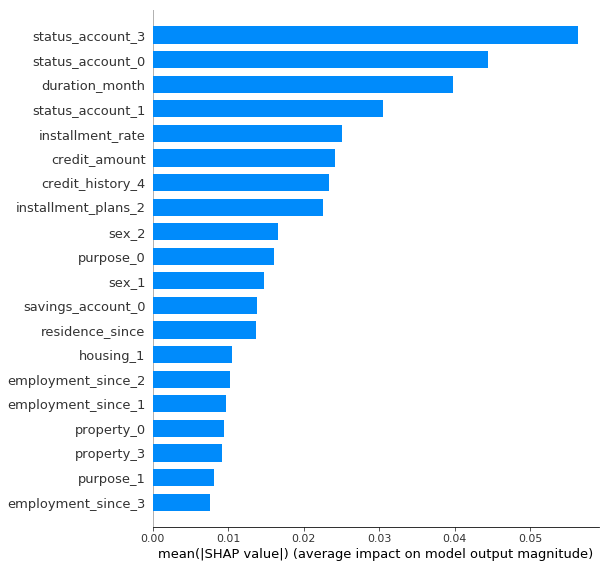

In [40]:
shap.summary_plot(shap_values_orig[0], X_test_orig, feature_names=dataset.feature_names, plot_type="bar")

In [41]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_orig[0]).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_orig_rf = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_orig_rf = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,status_account_3,0.056307
1,status_account_0,0.044466
2,duration_month,0.039815
3,status_account_1,0.030555
4,installment_rate,0.025147
5,credit_amount,0.024157
6,credit_history_4,0.023305
7,installment_plans_2,0.022543
8,sex_2,0.016571
9,purpose_0,0.016059


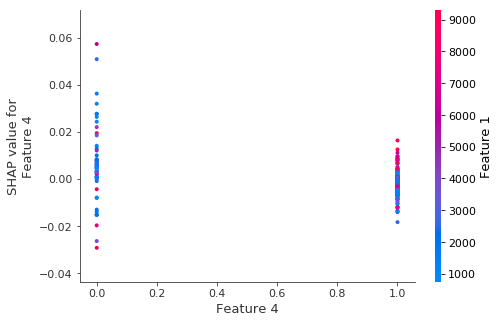

In [42]:
shap.dependence_plot(position, shap_values_orig[0], dataset_test.features)

In [43]:
df = pd.DataFrame({'shap': shap_values_orig[0][:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_orig_rf = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_orig_rf = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_orig_rf)
print('Media valores SHAP classe priveligiada: ', priv_value_orig_rf)

Media valores SHAP classe não priveligiada:  0.006104531503933083
Media valores SHAP classe priveligiada:  -0.0019072254840790765


In [44]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0

accept null hypothesis


In [0]:
lst_shape.append(('rf_orig', feat_import_orig_rf, pos_orig_rf,
                  unp_value_orig_rf, priv_value_orig_rf, priv_greater_unpriv))

In [46]:
prop_feat_import_rf = (feat_import_orig_rf - feat_import_transf_rf) / feat_import_orig_rf
print('Proporção diminuição da importancia: ', prop_feat_import_rf)

Proporção diminuição da importancia:  -1.167662026067705


### Logistic Regression

Estimating transforms: 100%|██████████| 1000/1000 [00:06<00:00, 160.65it/s]


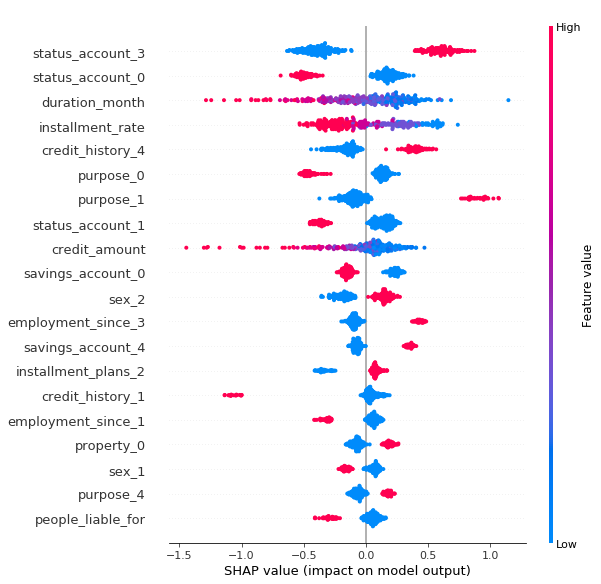

In [47]:
exp_transf_lr = shap.LinearExplainer(model_transf_lr, X_train_transf, feature_dependence="correlation")
shap_values_transf_lr = exp_transf_lr.shap_values(X_test_transf)
shap.summary_plot(shap_values_transf_lr, X_test_transf, feature_names=dataset.feature_names)

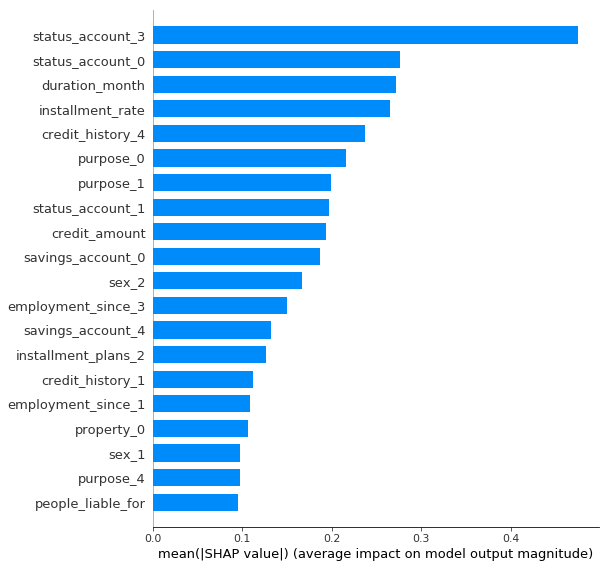

In [48]:
shap.summary_plot(shap_values_transf_lr, X_test_transf, feature_names=dataset.feature_names, plot_type="bar")

In [49]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_transf_lr).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_transf_lr = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_transf_lr = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,status_account_3,0.475086
1,status_account_0,0.276204
2,duration_month,0.272009
3,installment_rate,0.265584
4,credit_history_4,0.236910
5,purpose_0,0.216374
6,purpose_1,0.199780
7,status_account_1,0.196796
8,credit_amount,0.193381
9,savings_account_0,0.186593


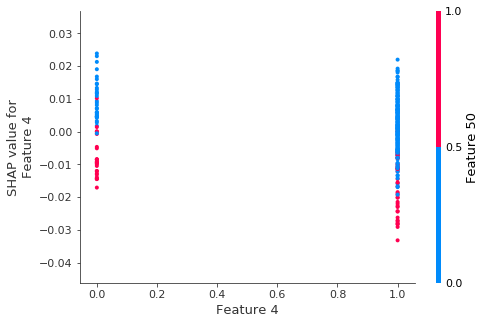

In [50]:
shap.dependence_plot(position, shap_values_transf_lr, dataset_test.features)

In [51]:
df = pd.DataFrame({'shap': shap_values_transf_lr[:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_transf_lr = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_transf_lr = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_transf_lr)
print('Media valores SHAP classe priveligiada: ', priv_value_transf_lr)

Media valores SHAP classe não priveligiada:  0.0019513632852587377
Media valores SHAP classe priveligiada:  -0.0009246139305946602


In [52]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0

accept null hypothesis


In [0]:
lst_shape.append(('lr_transf', feat_import_transf_lr, pos_transf_lr, 
                  unp_value_transf_lr, priv_value_transf_lr, priv_greater_unpriv))

Estimating transforms: 100%|██████████| 1000/1000 [00:06<00:00, 159.41it/s]


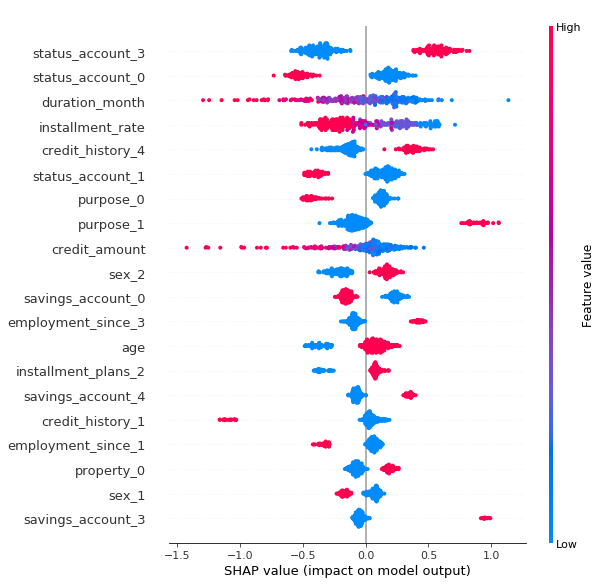

In [54]:
# exp_orig = shap.TreeExplainer(model, X_train_orig)
exp_orig_lr = shap.LinearExplainer(model_orig_lr, X_train_orig, feature_dependence="correlation")
shap_values_orig_lr = exp_orig_lr.shap_values(X_test_orig)
shap.summary_plot(shap_values_orig_lr, X_test_orig, feature_names=dataset.feature_names)

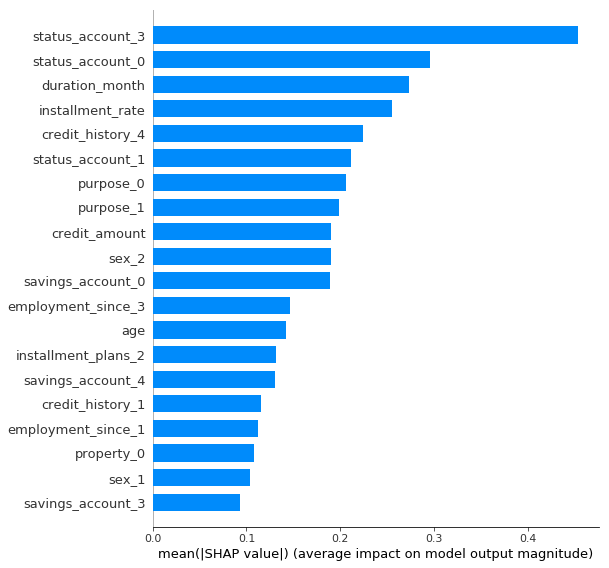

In [55]:
shap.summary_plot(shap_values_orig_lr, X_test_orig, feature_names=dataset.feature_names, plot_type="bar")

In [56]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_orig_lr).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_orig_lr = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_orig_lr = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,status_account_3,0.452839
1,status_account_0,0.295173
2,duration_month,0.273453
3,installment_rate,0.254836
4,credit_history_4,0.224144
5,status_account_1,0.211365
6,purpose_0,0.206406
7,purpose_1,0.198621
8,credit_amount,0.189891
9,sex_2,0.189537


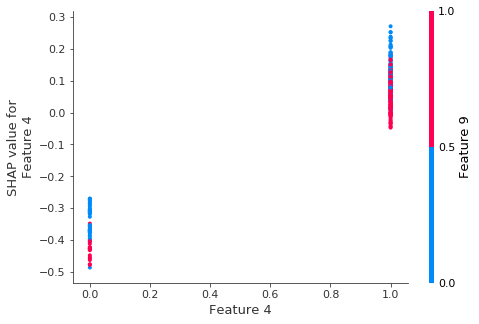

In [57]:
shap.dependence_plot(position, shap_values_orig_lr, dataset_test.features)

In [58]:
df = pd.DataFrame({'shap': shap_values_orig_lr[:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_orig_lr = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_orig_lr = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_orig_lr)
print('Media valores SHAP classe priveligiada: ', priv_value_orig_lr)

Media valores SHAP classe não priveligiada:  -0.366079587576437
Media valores SHAP classe priveligiada:  0.08539109832065019


In [59]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0

reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [0]:
lst_shape.append(('lr_orig', feat_import_orig_lr, pos_orig_lr,
                  unp_value_orig_lr, priv_value_orig_lr, priv_greater_unpriv))

In [61]:
prop_feat_import_lr = (feat_import_orig_lr - feat_import_transf_lr) / feat_import_orig_lr
print('Proporção diminuição da importancia: ', prop_feat_import_lr)

Proporção diminuição da importancia:  0.9390038930761996


In [62]:
df_shap = pd.DataFrame(lst_shape, columns=['name_exp', 'feat_imp', 'shap_rank', 'mean_unpriv', 'mean_priv', 'priv_greater_unpriv'])
df_final = pd.merge(df_shap, df_final, on='name_exp')
df_final

,name_exp,feat_imp,shap_rank,mean_unpriv,mean_priv,priv_greater_unpriv,dataset,acc_test,1_disp_impact_bin,mean_difference,1_disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,rf_transf,0.011002,13,0.020982,-0.007989,0,adult,0.753333,0.178488,-0.142348,0.178488,-0.065558,-0.092655,0.187074,0.102995,0.784000
1,rf_orig,0.005075,32,0.006105,-0.001907,0,adult,0.760000,0.144120,-0.116130,0.144120,-0.036684,-0.070621,0.195513,0.096743,0.792667
2,lr_transf,0.008663,58,0.001951,-0.000925,0,adult,0.756667,0.037135,-0.027928,0.037135,0.069825,-0.036723,0.250916,0.107529,0.809333
3,lr_orig,0.142030,12,-0.366080,0.085391,1,adult,0.763333,0.293198,-0.221716,0.293198,-0.129534,-0.170056,0.164111,0.112739,0.810667


In [0]:
df_final.to_csv(path+'result/resultado_german.csv')